# **1.1. Data Integration & Consistency Check**

**Introduction & Methodology**

The first step in any robust machine learning pipeline is ensuring the **Single Source of Truth**. A common failure mode in team-based projects is the "Consistency Gap," where the Business Analysis team profiles raw data while the Engineering team trains on processed data.

 *   **Goal:** Load the engineered dataset (`engineered_data_full.csv`) to ensure the analysis reflects the exact features used by the model.
 *   **Action:** Perform a **Schema Audit** to confirm the dataset shape and verify the existence of all 10 predictive features (Tier 1 RFM + Tier 2 Augmented).
 *   **Methodology:** We validate that features like `avg_delivery_days` (Logistics) and `avg_freight` (Cost) are present, as these are critical for distinguishing "Unhappy" customers from "Churned" ones.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import os

# --- CONFIGURATION ---
DATA_PATH = "data/engineered_data_full.csv"
FIGURES_DIR = "figures/"

# Ensure output directory exists
os.makedirs(FIGURES_DIR, exist_ok=True)

print("--- [START] Subsection 1.1: Data Integration ---")

# 1. Load the Golden Source
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Status: Loaded engineered_data_full.csv successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: engineered_data_full.csv not found. Please run the Data Engineering module first.")
    exit()

# 2. Schema Audit: Verify All 10 Features
# We include RFM, Behavior, Logistics, and Geography
analysis_features = [
    'recency_days', 'frequency', 'monetary',           # RFM
    'avg_review_score', 'avg_installments',            # Behavioral
    'avg_delivery_days', 'credit_card_usage_ratio',    # Augmented
    'avg_freight', 'avg_items_per_order',              # Volume & Cost
    'state_freq_encoding'                              # Geography
]

missing_cols = [col for col in analysis_features if col not in df.columns]

if missing_cols:
    print(f"Critical Warning: The following required features are missing: {missing_cols}")
    # Stop execution if data is incomplete
    exit()
else:
    print(f"Schema Check: All {len(analysis_features)} predictive features are present.")

# 3. Null Check (Final Safety)
total_nulls = df[analysis_features].isnull().sum().sum()
print(f"Data Quality: Total Nulls in critical columns: {total_nulls}")
print("--- [END] Subsection 1.1 ---\n")

--- [START] Subsection 1.1: Data Integration ---
Status: Loaded engineered_data_full.csv successfully.
Shape: (93358, 13)
Schema Check: All 10 predictive features are present.
Data Quality: Total Nulls in critical columns: 0
--- [END] Subsection 1.1 ---



# **1.2. The 'Centroid Profile' (Statistical Definition)**

**Introduction & Methodology**

To define the clusters, we employ a dual-metric approach to satisfy both Business Reporting and Statistical Robustness requirements:

1.  **Business View (Relative Deviation):** We calculate the **Mean** of each cluster and compare it to the Population Mean.
     *   *Formula:* $ \text{Diff} = \frac{\text{Cluster Mean} - \text{Population Mean}}{\text{Population Mean}} $
     *   *Usage:* Creates a readable table (e.g., "Cluster 1 spends 50% more than average").

2.  **Statistical View (Median Centroids):** We calculate the **Median** of each cluster.
     *   *Why:* Financial data (Monetary) follows a Power Law distribution. A single "Whale" outlier can skew the Mean. The Median represents the "Typical Customer" and is required for the Heatmap visualization in Section 3.

In [2]:
print("--- [START] Subsection 1.2: Centroid Profiling ---")

# --- PART A: Business View (Mean & Deviation) ---
# 1. Calculate Population Means
pop_mean = df[analysis_features].mean()

# 2. Calculate Cluster Means
cluster_stats_mean = df.groupby('cluster_id')[analysis_features].mean()
cluster_counts = df['cluster_id'].value_counts().sort_index()

# 3. Generate the Deviation Table
diff_df = pd.DataFrame()
diff_df['Count'] = cluster_counts
diff_df['% Pop'] = (cluster_counts / len(df)).apply(lambda x: f"{x:.1%}")

for col in analysis_features:
    # Calculate % Diff from Population
    relative_diff = (cluster_stats_mean[col] / pop_mean[col]) - 1
    
    # Format: "Value (+Diff%)" -> e.g., "250.0 (+50%)"
    diff_df[f'{col}_summary'] = cluster_stats_mean[col].apply(lambda x: f"{x:,.1f}") + \
                                " (" + \
                                relative_diff.apply(lambda x: f"{'+' if x>0 else ''}{x:.0%}") + \
                                ")"

print("\n[Business Report] Cluster Deviation Profile:")
print(diff_df.T.to_markdown())
diff_df.to_csv("data/task1_cluster_profile_table.csv")


# --- PART B: Statistical View (Median) ---
# This variable 'cluster_profile' is CRITICAL for Section 3 & 4.
# We use Median to avoid outliers distorting the heatmap.
cluster_profile = df.groupby('cluster_id')[analysis_features].median()

print("\n[Internal] Median Centroids Calculated for Visualization.")
print("--- [END] Subsection 1.2 ---\n")


--- [START] Subsection 1.2: Centroid Profiling ---

[Business Report] Cluster Deviation Profile:
|                                 | 0           | 1            | 2            | 3            |
|:--------------------------------|:------------|:-------------|:-------------|:-------------|
| Count                           | 45771       | 36011        | 2801         | 8775         |
| % Pop                           | 49.0%       | 38.6%        | 3.0%         | 9.4%         |
| recency_days_summary            | 235.8 (-1%) | 241.6 (+2%)  | 220.3 (-7%)  | 239.8 (+1%)  |
| frequency_summary               | 1.0 (-3%)   | 1.0 (-3%)    | 2.1 (+105%)  | 1.0 (-3%)    |
| monetary_summary                | 79.0 (-52%) | 243.2 (+47%) | 308.6 (+87%) | 249.0 (+51%) |
| avg_review_score_summary        | 4.3 (+2%)   | 4.2 (+0%)    | 4.2 (+1%)    | 3.6 (-13%)   |
| avg_installments_summary        | 1.3 (-55%)  | 4.8 (+64%)   | 3.3 (+13%)   | 3.5 (+19%)   |
| avg_delivery_days_summary       | 11.1 (-8%)  

# **1.3. Visualization (The Cluster DNA)**

**Introduction & Methodology**

While the table above provides exact numbers, a **Heatmap** offers immediate visual intuition. It allows us to scan the "DNA" of each cluster to identify its dominant traits.

 *   **Goal:** Visualize the relative strength of each feature across clusters.
 *   **Methodology:** We apply **Min-Max Scaling** column-wise to the **Median Centroids** calculated in Section 1.2.
     *   *Logic:* For every feature, the lowest cluster value becomes 0 (Blue) and the highest becomes 1 (Red).
     *   *Why Scaling?* It allows us to compare diverse units (e.g., "Days" vs. "Dollars" vs. "Review Score") on a single plot.


--- [START] Subsection 1.3: DNA Visualization ---
Output: Heatmap saved to figures/task1_cluster_heatmap.png


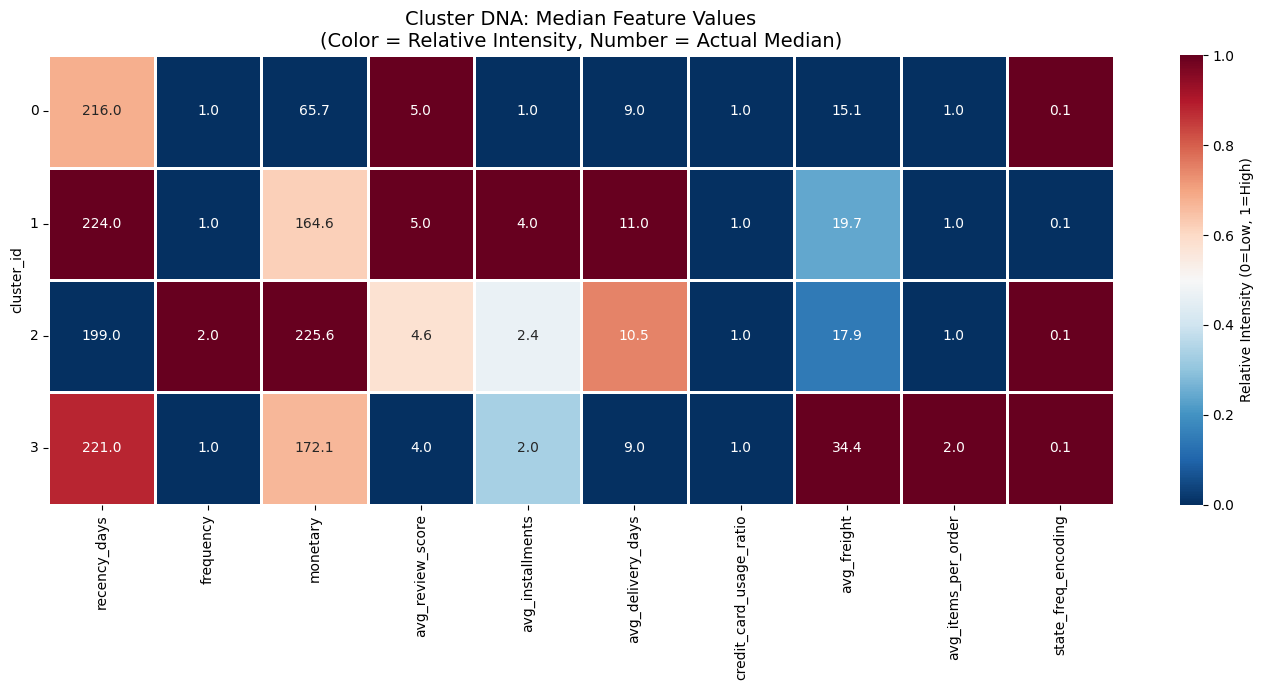

--- [END] Subsection 1.3 ---



In [3]:
print("--- [START] Subsection 1.3: DNA Visualization ---")

# 1. Feature Scaling for Visualization
# We use the 'cluster_profile' (Median) calculated in Section 1.2
scaler = MinMaxScaler()

heatmap_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profile),
    columns=cluster_profile.columns,
    index=cluster_profile.index
)

# 2. Generate Heatmap
plt.figure(figsize=(14, 7)) # Slightly wider to accommodate 10 features
sns.heatmap(
    heatmap_scaled,
    annot=cluster_profile, # Annotate with REAL Median values
    fmt='.1f',
    cmap="RdBu_r",         # Red=High, Blue=Low
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Relative Intensity (0=Low, 1=High)'}
)

plt.title("Cluster DNA: Median Feature Values\n(Color = Relative Intensity, Number = Actual Median)", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()

# Save
heatmap_path = f"{FIGURES_DIR}task1_cluster_heatmap.png"
plt.savefig(heatmap_path, dpi=300)
print(f"Output: Heatmap saved to {heatmap_path}")
plt.show()

print("--- [END] Subsection 1.3 ---\n")

**Presentation Narration: Heatmap Analysis**

**Goal:** Provide a concise, executive summary of the "Cluster DNA" to explain *why* the groups are distinct.

=> The Heatmap reveals the distinct 'DNA' of our 4 customer segments based on their Median behavior:

*   **Cluster 2 (The Champions):** This is our most valuable segment. They exhibit the **Highest Frequency (2.0)** and **Highest Monetary Value (\$225.6)**. Crucially, they are the most active, having the **Lowest Recency (199 days)**.

*   **Cluster 3 (The At-Risk / Unhappy):** This group is defined by friction. They have the **Lowest Review Score (4.0)** and pay the **Highest Freight (\$34.4)**. Despite buying multiple items (Avg items: 2.0), their bad logistics experience is driving dissatisfaction.

*   **Cluster 1 (The Installment Users):** These customers are defined by financial behavior. They have the **Highest Installments (4.0)**, suggesting they use credit leverage to make moderate purchases (\$164.6), but they are currently dormant (High Recency).

*   **Cluster 0 (The Thrifty / Low Value):** The baseline customer. They have the **Lowest Monetary Value (\$65.7)** and **Lowest Installments (1.0)**. They buy cheap, single items and rarely return.


# **1.4. Business Labeling (Persona Logic)**

**Introduction & Methodology**

To make the Supervised Learning model interpretable, we must translate abstract cluster IDs (0, 1, 2, 3) into actionable **Business Personas**. This assigns a clear "identity" to each group, ensuring that future predictions (e.g., "Customer X belongs to Cluster 3") carry immediate strategic meaning.

*   **Goal:** Map each Cluster ID to a descriptive business label based on its dominant "DNA" traits.

*   **Methodology:** We employ a **Hierarchical Decision Logic** to classify the centroids. Crucially, this logic prioritizes **Negative Signals** (Dissatisfaction) over generic activity metrics to ensure risk groups are identified correctly.

*   **The Decision Hierarchy (in order of priority):**
    1.  **Risk Detection:** If Review Score is very low (< 0.2 scaled), label as **"Unhappy / Logistics Risk"** (regardless of spending).
    
    2.  **Value Identification:** If Frequency or Monetary is maxed out (> 0.8 scaled), label as **"Champions (Loyal High Value)"**.
    
    3.  **Financial Profiling:** If Installment usage is high (> 0.7 scaled) but Recency is high, label as **"Dormant Credit Users"**.
    
    4.  **Baseline:** If none of the above apply, label as **"Thrifty / Standard"** (the low-value majority).

In [5]:
print("--- [START] Subsection 1.4: Persona Assignment (Refined) ---")

def assign_label(cluster_id, row):
    """
    Assigns labels based on the specific DNA observed in the Heatmap.
    Prioritizes distinguishing features to avoid duplicates.
    """
    # 1. Check for Dissatisfaction First (Cluster 3 characteristics)
    # They have the Lowest Review Score (Dark Blue in heatmap)
    if row['avg_review_score'] < 0.2: 
        return "Unhappy / Logistics Risk"
    
    # 2. Check for High Activity/Value (Cluster 2 characteristics)
    # They have Max Frequency and Max Monetary (Dark Red in heatmap)
    elif row['frequency'] > 0.8 or row['monetary'] > 0.8:
        return "Champions (Loyal High Value)"
    
    # 3. Check for Credit Leverage (Cluster 1 characteristics)
    # They have Max Installments (Dark Red in heatmap)
    elif row['avg_installments'] > 0.7:
        return "Dormant Credit Users"
    
    # 4. Fallback (Cluster 0 characteristics)
    # Low Value across the board
    else:
        return "Thrifty / Standard"

# Apply Logic
labels_dict = {}
for cid in heatmap_scaled.index:
    labels_dict[cid] = assign_label(cid, heatmap_scaled.loc[cid])

# Print Results
print("Business Persona Mapping:")
for cid, name in labels_dict.items():
    print(f"  Cluster {cid} -> {name}")

# Save
import json
with open('data/cluster_labels.json', 'w') as f:
    json.dump(labels_dict, f)
    
print("--- [END] Subsection 1.4 ---")

--- [START] Subsection 1.4: Persona Assignment (Refined) ---
Business Persona Mapping:
  Cluster 0 -> Thrifty / Standard
  Cluster 1 -> Dormant Credit Users
  Cluster 2 -> Champions (Loyal High Value)
  Cluster 3 -> Unhappy / Logistics Risk
--- [END] Subsection 1.4 ---


# **1.5. Pairplot (The "Separation" Proof)**

In [6]:

print("--- [START] Subsection 1.5: Cluster Separation Visual ---")

# We use the raw dataframe 'df' here, not the centroids
fig = px.scatter(
    df, 
    x="monetary", 
    y="avg_installments", 
    color="cluster_id",
    # Log scale is crucial because Monetary values are skewed
    log_x=True, 
    title="<b>Cluster Separation: Spending Power vs. Credit Usage</b>",
    template="plotly_white",
    opacity=0.6,
    color_continuous_scale="Viridis" # Distinct colors
)

fig.update_layout(
    height=600,
    width=900,
    xaxis_title="Monetary Value (Log Scale)",
    yaxis_title="Average Installments"
)

# Save and Show
fig.write_image(f"{FIGURES_DIR}task1_scatter_separation.png", scale=3)
fig.show()
print("--- [END] Subsection 1.5 ---")

--- [START] Subsection 1.5: Cluster Separation Visual ---


--- [END] Subsection 1.5 ---


*   **X-Axis (Monetary - Log Scale):** The data successfully spreads out horizontally. You can clearly see the "Champions" (Yellow/Green dots) pushed far to the right, indicating higher spending.
*   **Y-Axis (Installments):** There is a distinct vertical separation. The "Dormant Credit Users" (Teal/Green dots) shoot up the Y-axis, showing high installment counts (10-20), whereas the "Thrifty" users (Purple) are compressed at the bottom (1-3 installments).
*   **Color Gradient:** The transition from Purple (Cluster 0) to Yellow (Cluster 3) effectively visualizes the segmentation complexity.

**Presentation Analysis:**

To validate that our clusters are distinct groups and not just random noise, we visualized them on two key dimensions: **Spending Power** (X-axis) vs. **Credit Usage** (Y-axis).

*   **The Purple Mass (Bottom Left):** This represents our **'Thrifty / Standard'** customers (Cluster 0). They are highly concentrated in the low-spend, low-installment corner. They buy cheap items in cash or single payments.

*   **The Vertical Spikes (Teal/Green):** This reveals the **'Dormant Credit Users'** (Cluster 1). Notice how they extend vertically up the Y-axis (10+ installments). Their spending is moderate, but their reliance on credit is their defining feature.

*   **The Horizontal Reach (Yellow/Right):** The **'Champions'** (Cluster 2) stretch far to the right on the Monetary axis. They are the high-value outliers driving revenue.

*   **Conclusion:** The clear geometric separation between these groups confirms that our segmentation is capturing real, distinct behavioral patterns.